#PRELIMINARIES

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Preliminaries:
url_train = "https://github.com/lakigigar/Caltech-CS155-2021/blob/main/projects/project1/WILDFIRES_TRAIN.zip?raw=TRUE"
url_test = "https://github.com/lakigigar/Caltech-CS155-2021/blob/main/projects/project1/WILDFIRES_TEST.zip?raw=TRUE"
df_train = pd.read_csv(url_train, compression="zip", index_col="id")
df_test = pd.read_csv(url_test, compression = "zip", index_col="id")

In [ ]:
#Peek at data
df_train

,LATITUDE,LONGITUDE,STATE,DISCOVERY_TIME,FIRE_SIZE,FIPS_NAME,FIPS_CODE,SOURCE_REPORTING_UNIT_NAME,DATE,LABEL
id,,,,,,,,,,
0,38.205000,-120.335000,CA,130.0,0.10,NaN,NaN,Stanislaus National Forest,1992-01-01,1
1,33.813100,-85.104300,GA,1115.0,1.17,Haralson,143.0,Georgia Forestry Commission,1992-01-01,4
2,32.201000,-82.498700,GA,1600.0,0.07,Montgomery,209.0,Georgia Forestry Commission,1992-01-01,2
3,32.509300,-81.708600,GA,1215.0,4.40,Bulloch,31.0,Georgia Forestry Commission,1992-01-01,4
4,33.663889,-116.171944,CA,NaN,0.20,NaN,NaN,CDF - Riverside Unit,1992-01-01,2
...,...,...,...,...,...,...,...,...,...,...
285377,32.359105,-82.893909,GA,NaN,0.25,Laurens,175.0,"GAS Ogeechee District, McRae Office",2009-12-30,4
285378,38.346342,-120.855472,CA,1031.0,0.10,NaN,NaN,Amador-El Dorado Unit,2009-12-30,2
285379,32.780596,-82.742433,GA,NaN,0.01,Johnson,167.0,"GAS Oconee District, Milledgeville Office",2009-12-30,2


#DATA: FORMATTING

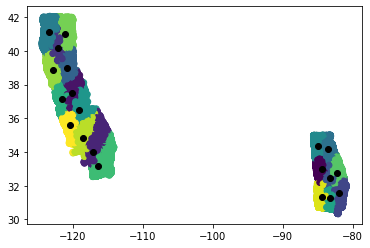

,FIRE_SIZE,LABEL,DAY_OF_YR,FIPCOD_CAT,SRCNAM_CAT,SCALED_TIME,CLUSTER_ID
id,,,,,,,
0,0.10,1,1,-1,157,-3.095307,1
1,1.17,4,1,72,71,-0.728639,9
2,0.07,2,1,104,71,0.436674,14
3,4.40,4,1,16,71,-0.488369,14
4,0.20,2,1,-1,14,-1.000000,13
...,...,...,...,...,...,...,...
285377,0.25,4,364,88,55,-1.000000,5
285378,0.10,2,364,-1,0,-0.930467,6
285379,0.01,2,364,84,53,-1.000000,14


In [ ]:
''' HEADS UP: I have a starred-out part in each code block with defined measures
 from previous testing, as well as an empty selection below if you want to 
 experiment.'''

#Data has a lot of NaNs and three features of categorical data, which we must first transform
#Anything we do to the training data, we must also do to the testing data

#Let's build a dataframe of the input data we already have in usable form
input_data = df_train[["FIRE_SIZE", "LABEL"]].copy()
test_data = df_test[['FIRE_SIZE']].copy()

#********************** KNOWN DATA EDITS ***************************************
#Date column:
#For dates, the most information will likely come from the day of the year, which
#should capture monthly and seasonal data in a continuous spread.
from datetime import datetime
day_of_year=df_train['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timetuple().tm_yday)
input_data["DAY_OF_YR"] = day_of_year

day_test = df_test['DATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timetuple().tm_yday)
test_data['DAY_OF_YR'] = day_test

#State Column:
#The only states in the data set are GA/CA, so we can one-hot these
#states = pd.get_dummies(df_train['STATE'])
#input_data[["CA", "GA"]]=states

#states_test = pd.get_dummies(df_test['STATE'])
#test_data[["CA", "GA"]] = states_test

#For the name columns, there are about ~200 unique features for each, we should label-encode these
#This has an added advantage from turning NaNs into another category, rather than excising NaN entries
#NOTICE: FIPS_NAME and FIPS_CODE are perfectly correlated (the code gives the id number of name),
# So there is only need to use one of these two columns. Let's use FIP_CODE.
#SOURCE_REPORTING_UNIT_NAME, FIPS_CODE Columns:
fipscategories = df_train["FIPS_CODE"].astype('category').cat.categories
namecategories = df_train["SOURCE_REPORTING_UNIT_NAME"].astype('category').cat.categories

fipcdlbl = df_train["FIPS_CODE"].astype('category').cat.codes
srcnamelbl = df_train["SOURCE_REPORTING_UNIT_NAME"].astype('category').cat.codes
input_data["FIPCOD_CAT"] = fipcdlbl
input_data["SRCNAM_CAT"] = srcnamelbl

srcnamelbl_test = pd.Series(pd.Categorical(df_test['SOURCE_REPORTING_UNIT_NAME'].to_list(),
               categories=namecategories)).cat.codes.values
fipcdlbl_test = pd.Series(pd.Categorical(df_test['FIPS_CODE'].to_list(),
               categories=fipscategories)).cat.codes.values
test_data["FIPCOD_CAT" ] = fipcdlbl_test
test_data["SRCNAM_CAT"] = srcnamelbl_test

#The only remaining NaNs in the dataset are in the discovery time column
#Let's normalize this column and give the NaNs a -1:
times = df_train["DISCOVERY_TIME"].to_numpy()
goodtimes = times[~np.isnan(times)]
goodtimes = (goodtimes-np.average(goodtimes))/np.std(goodtimes)
times[~np.isnan(times)]=goodtimes
times[np.isnan(times)]=-1
input_data["SCALED_TIME"]=times

time_test = df_test['DISCOVERY_TIME'].to_numpy()
time_test = (time_test - np.average(goodtimes))/np.std(goodtimes)
time_test[np.isnan(time_test)]=-1
test_data["SCALED_TIME"] = time_test


#Now let's make cluster labels instead of lat/lon:
from sklearn.cluster import KMeans
clusters = KMeans(20).fit(df_train[['LATITUDE', 'LONGITUDE']])
plt.scatter(df_train['LONGITUDE'], df_train['LATITUDE'], c = clusters.labels_)
plt.scatter(clusters.cluster_centers_[:,1], clusters.cluster_centers_[:,0], c = "black")
plt.show()
input_data['CLUSTER_ID'] = clusters.labels_

test_clusters = clusters.predict(df_test[['LATITUDE', 'LONGITUDE']])
test_data['CLUSTER_ID'] = test_clusters


#********************** END DATA EDITS *****************************************

'''Test any others you're interested in here/below.
#Remember, anything you do to training must be done to testing, and any scaling,
#subtraction, multiplication, etc must be done with the values found on the
#TRAINING set, even onto the test set'''

#Peek at data now
input_data

# DATA: CLEANING/SCALING

,FIRE_SIZE,LABEL,DAY_OF_YR,FIPCOD_CAT,SRCNAM_CAT,SCALED_TIME,CLUSTER_ID
id,,,,,,,
0,0.10,1,0.002732,-1,157,-3.095307,1
1,1.17,4,0.002732,72,71,-0.728639,9
2,0.07,2,0.002732,104,71,0.436674,14
3,4.40,4,0.002732,16,71,-0.488369,14
4,0.20,2,0.002732,-1,14,-1.000000,13
...,...,...,...,...,...,...,...
285377,0.25,4,0.994536,88,55,-1.000000,5
285378,0.10,2,0.994536,-1,0,-0.930467,6
285379,0.01,2,0.994536,84,53,-1.000000,14


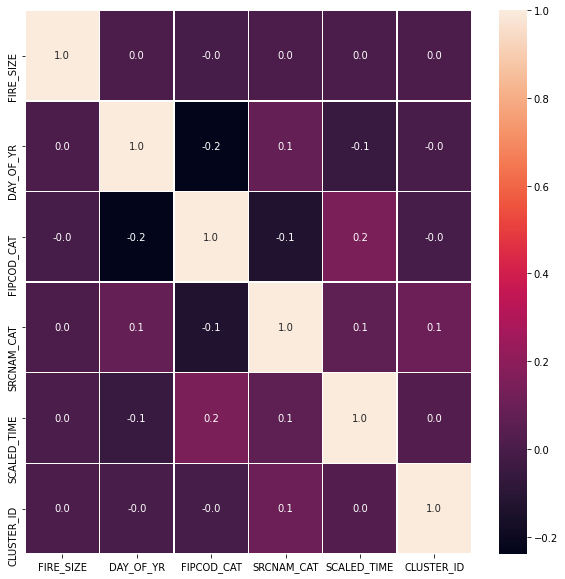

In [98]:
#************* KNOWN CLEANING PROCEDURES ***************************************
#Scale most numerical predictor variables to be within the same range
# (Do not do this for categorical data)
#latmean = input_data['LATITUDE'].mean()
#latstd = input_data['LATITUDE'].std()
#lonmean = input_data['LONGITUDE'].mean()
#lonstd = input_data['LONGITUDE'].std()
daymax = input_data['DAY_OF_YR'].max()
#input_data['LATITUDE']=(input_data['LATITUDE']-latmean)/latstd
#input_data['LONGITUDE']=(input_data['LONGITUDE']-lonmean)/lonstd
input_data['DAY_OF_YR']=input_data['DAY_OF_YR']/daymax

#test_data['LATITUDE'] = (test_data['LATITUDE']-latmean)/latstd
#test_data['LONGITUDE'] = (test_data['LONGITUDE']-lonmean)/lonstd
test_data['DAY_OF_YR']=test_data['DAY_OF_YR']/daymax

#Remove highly-correlated predictors, unless explicitly desired
import seaborn as sns
cors = input_data.drop(columns = "LABEL").corr()
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cors, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# I choose to drop none and keep them (see comment on the FIPS_NAME above)

#*******************************************************************************

'''Test any others you're interested in below. Same warning applies for doing the
same to the test set as you would to the training.'''

#OTHER OPTIONS TO CONSIDER:
# - NaN-replacement (replace NaNs with numerical mean/median or cateogorical mode)

input_data

#SET-UP FOR MODEL TRAINING

In [ ]:
#Now that we have usable data, we should split the resulting data into sets for cross-validation, and separate by input/output
from sklearn.model_selection import KFold

#Use standard 5-fold cross-validation
nsplits = 5
kf = KFold(n_splits = nsplits, shuffle = True)

output = input_data['LABEL']
input = input_data.drop(columns = 'LABEL')

#TRAIN/EVALUATE A CHOSEN MODEL TYPE

In [ ]:
from sklearn.metrics import roc_auc_score as evalmetric
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

results = np.zeros(nsplits)
idx = 0
clfs = []
for train_index, test_index in kf.split(input_data):
     print("ON SET: ", idx+1)
     X_train, X_test = input.iloc[train_index], input.iloc[test_index]
     y_train, y_test = output.iloc[train_index], output.iloc[test_index]
     
     #METHOD 1: This one tries a random-forest
     clf = RandomForestClassifier(n_estimators=200, max_depth = 20,
                                  criterion='gini', max_samples = 100000)
     clf.fit(X_train, y_train)
     ''' for a more complex model, we'll have to scrap storing the models
         in RAM, unless someone wants to try this locally. alternatively, one 
         could store one model and update it if the evaluation score improves.
         Leaving this commented out just means we use the last model.'''
     #clfs.append(clf)
     #predictedlabels = clf.predict(X_test)

     #METHOD 2: Try gradient boosting
     #clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5,
     #    max_depth=3)
     #clf.fit(X_train, y_train)
     #predictedlabels = clf.predict(X_test)

     #After choosing model to train (comment out others), calculate eval metric     
     testlabels = y_test.to_numpy()
     metric = evalmetric(testlabels, clf.predict_proba(X_test), multi_class = "ovr")
     results[idx] = metric
     print("Score: ", metric)
     idx = idx + 1



ON SET:  1
Score:  0.8103418903126549
ON SET:  2
Score:  0.8086107766123818
ON SET:  3
Score:  0.8092013614356995
ON SET:  4
Score:  0.8088686192152196
ON SET:  5
Score:  0.8093502612550924


#SUMMARY OF TRAINING

In [95]:
#Add whatever other summarries you want to add
#Benchmark to beat by TAs is 75.3%

print(results)
print("Average success across kfolds: ", np.average(results))
print("On entire dataset: ", evalmetric(input_data['LABEL'].values, clf.predict_proba(input), multi_class = "ovr"))

[0.81034189 0.80861078 0.80920136 0.80886862 0.80935026]
Average success across kfolds:  0.8092745817662095
On entire dataset:  0.9124814635417005


#GENERATE TESTING FILE AND REPORT TEST METRICS



In [96]:
#Now that we know the model type we would like, use it to generate the output file:

'''only uncomment if you've stored all the clfs'''
#used_clf = clfs[np.argmax(results)]
#probs = used_clf.predict_proba(test_data)

'''use this if you haven't stored the clfs'''
probs = clf.predict_proba(test_data)
print(probs)

#WRITE TO CSV
output = pd.DataFrame(probs, columns = ["P1", "P2", "P3", "P4"])
output['id'] = test_data.index
output = output.set_index('id')
output.to_csv("test_predictions.csv")

[[2.00000000e-02 3.86666667e-01 2.15000000e-01 3.78333333e-01]
 [8.00000000e-02 2.58181818e-01 2.45454545e-01 4.16363636e-01]
 [7.50000000e-02 3.95000000e-01 2.75000000e-01 2.55000000e-01]
 ...
 [1.05000000e-01 3.25000000e-01 1.10000000e-01 4.60000000e-01]
 [2.17391304e-04 4.71595031e-01 1.68536506e-01 3.59651072e-01]
 [9.50000000e-02 3.57204545e-01 1.57318182e-01 3.90477273e-01]]


#ATTEMPTING A NEURAL NETWORK

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing

class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


#Now we must scale ALL entries to 0/1 for a neural net:
input_data2 = input_data.copy()
output = input_data2['LABEL']
input = input_data2.drop(columns = 'LABEL')
x = input.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
input = pd.DataFrame(x_scaled)

idx = np.arange(285382)
idx = np.random.permutation(idx)
input_train = input.iloc[idx[0:205381]]
output_train = output.iloc[idx[0:205381]]-1
input_test = input.iloc[idx[205381:285381]] # test size of 80,000
output_test = output.iloc[idx[205381:285381]]-1


train_dataset = ClassifierDataset(torch.from_numpy(input_train.to_numpy()).float(), torch.from_numpy(output_train.to_numpy()))
test_dataset = ClassifierDataset(torch.from_numpy(input_test.to_numpy()).float(), torch.from_numpy(output_test.to_numpy()))


model = nn.Sequential(
    #nn.Flatten(),  
    nn.Linear(6, 6),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(6, 12),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(12, 4),
    nn.Softmax()
)


optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)

model.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # Erase accumulated gradients
        optimizer.zero_grad()
        # Forward pass
        outputn = model(data)
        # Calculate loss
        loss = loss_fn(outputn, target)
        # Backward pass
        loss.backward()
        # Weight update
        optimizer.step()
    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

cuda


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1  Loss: 1.1437
Train Epoch: 2  Loss: 1.3437
Train Epoch: 3  Loss: 1.1437
Train Epoch: 4  Loss: 1.3437
Train Epoch: 5  Loss: 1.1437
Train Epoch: 6  Loss: 0.7437
Train Epoch: 7  Loss: 1.3437
Train Epoch: 8  Loss: 0.9437
Train Epoch: 9  Loss: 0.9437
Train Epoch: 10  Loss: 1.3437


In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

predictions = np.zeros((80000, 4))
truelabels = np.zeros((80000, 1))
# Turning off automatic differentiation
with torch.no_grad():
    idx = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputn = model(data)
        test_loss += loss_fn(outputn, target).item()  # Sum up batch loss
        pred = outputn.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()
        predictions[idx*len(target):idx*len(target)+len(target), :] = outputn.cpu().numpy()
        truelabels[idx*len(target):idx*len(target)+len(target)] = target.cpu().numpy().reshape((32,1))
        idx = idx + 1

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test set: Average loss: 0.0367, Accuracy: 45599/80000 (56.9988)


In [ ]:
#Check model score:
from sklearn.metrics import roc_auc_score as evalmetric
metric = evalmetric(truelabels, predictions, multi_class = "ovr")
print(metric)

0.49663030034286326
